In [1]:
from lib.train import gridsearch_inputer
from lib.prepare_data import make_cut, to_categorical
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import sys
import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning) 

In [2]:
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

spark = SparkSession \
    .builder \
    .appName("renovation") \
    .getOrCreate()

# set this parameter for date issue before 1582 (dpe database)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [3]:
# import files
# File location and type
file_location_array = [
    {"location": "../training/pred_tremi.csv",
        "name": "pred_tremi_full", "delimiter": ","},
    {"location": "../training/dico.csv", "name": "dictionary", "delimiter": "\t"}
]
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
dataframes = {}

# The applied options are for CSV files. For other file types, these will be ignored.
for file in file_location_array:
    delimiter = file["delimiter"]
    file_location = file["location"]
    name = file["name"]
    dataframes[file["name"]] = (
        spark.read.format(file_type)
        .option("inferSchema", infer_schema)
        .option("header", first_row_is_header)
        .option("sep", delimiter)
        .load(file_location)
    )

In [4]:
# name the important datasets and cast to type
training_tremi = (
    dataframes['pred_tremi_full'].withColumns({
        'surface': F.col('surface').cast('float'),
        'heating_production': F.col('heating_production').cast('float'),
        'heating_emission': F.col('heating_emission').cast('float')
    })
)

dictionary = dataframes['dictionary']

In [5]:
from copy import deepcopy
from sklearn.model_selection import ShuffleSplit
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.impute import KNNImputer
from lib.show import score_plot
from lib.prepare_data import get_predict_set

In [6]:
# make the best split
best_cut=(70,45,1)
cuts = make_cut(*best_cut)
training_tremi, coef = to_categorical(training_tremi, 'surface', cuts)
display(training_tremi)

# prepare data
truth = training_tremi.filter(
    (F.col('surface').isNotNull()) &
    (F.col('heating_production').isNotNull()) &
    (F.col('heating_emission').isNotNull())
).toPandas().to_numpy()

training = deepcopy(truth)

split = ShuffleSplit(n_splits=3, random_state=42, test_size=0.4).split(truth)
list_split = list(split)

for i, (_, test_index) in enumerate(list_split):
    for index in test_index:
        training[index][-(i+1)] = np.nan

DataFrame[gender: int, age: int, occupation: int, home_state: int, nb_persons_home: int, income: int, type: int, construction_date: int, heating_system: int, population: int, n_development_licence: int, n_construction_licence: int, n_new_buildings: int, n_destruction_licence: int, department_number: int, surface: int, heating_production: float, heating_emission: float]

In [7]:
# librairies
from lib.usefull import *
import numpy as np
import seaborn as sn
import sklearn as sk
import pyspark as ps
import pandas as pd
import matplotlib as matplot
import matplotlib.pyplot as plt

# score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# XGboost
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier

# quick XGboost
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingRegressor

Dataframe = ps.sql.dataframe.DataFrame
Axe = matplot.axes._axes.Axes
Model = XGBRegressor | XGBClassifier | RandomForestClassifier | RandomForestRegressor | Ridge | LogisticRegression | HistGradientBoostingRegressor | HistGradientBoostingClassifier


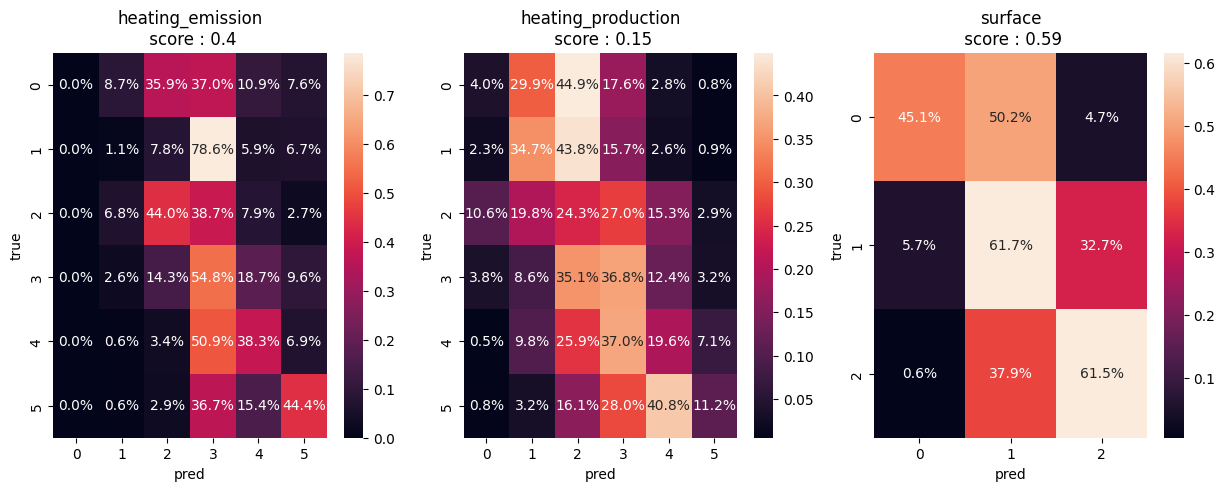

In [8]:

imp = IterativeImputer(max_iter=10, random_state=42, min_value=[-np.inf for _ in range(15)] + [0,1,1], max_value=[np.inf for _ in range(15)] + [np.inf,6,6])
pred = imp.fit_transform(training)

y_true = get_predict_set(truth, list_split)
y_pred = np.rint(get_predict_set(pred, list_split))

score_plot(y_pred, y_true,['heating_emission', 'heating_production', 'surface'])

14
5
10
0.4124115077571924 {'weights': 'uniform', 'n_neighbors': 1}


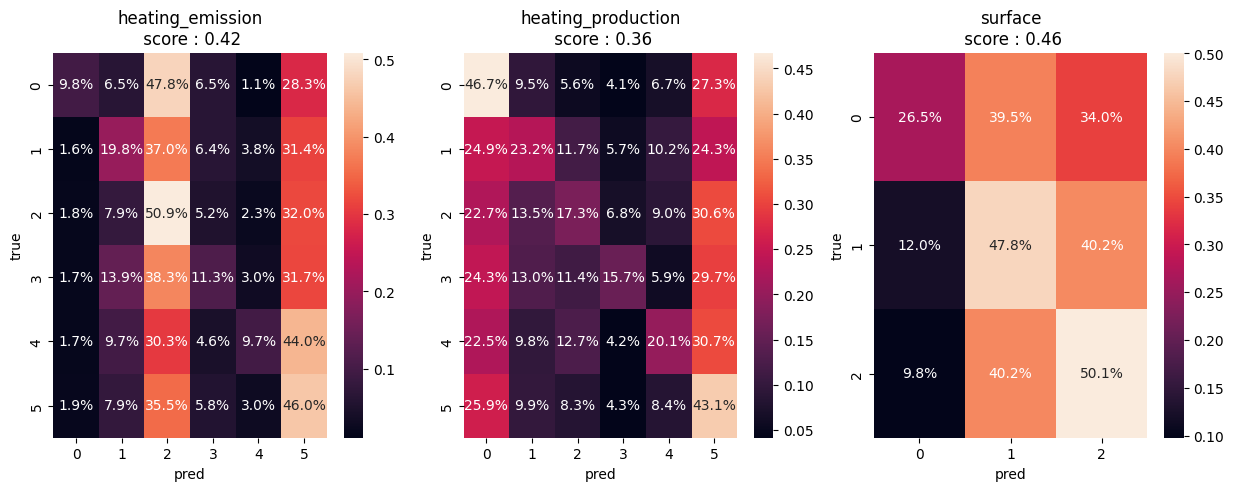

In [9]:
hyperparams = {
    'weights' : ['uniform', 'distance'],
    'n_neighbors' : [i for i in range(1,8)]
}    
scores, max_score, best_params  = gridsearch_inputer(KNNImputer, hyperparams, training, truth, list_split)

knn = KNNImputer(**best_params)
pred = knn.fit_transform(training)
y_true = get_predict_set(truth, list_split)
y_pred = np.rint(get_predict_set(pred, list_split))
score_plot(y_pred, y_true,['heating_emission', 'heating_production', 'surface'])